In [7]:
from matplotlib import pyplot as plt
from src.ml.data.data_loader import load_raw_data
from sklearn.cluster import KMeans

processed_data_path = '/Users/aya/Desktop/ML/insurance-recommender/data/processed/processed_user_data.csv'
processed_user_data = load_raw_data(processed_data_path)
processed_user_data

,_id,PCA1,PCA2,PCA3
0,65a713cc1dfebcf6ca173f0d,-2.270148,0.374166,-0.640058
1,65a714291dfebcf6ca173f0e,-2.197261,0.106193,1.400659
2,65a714641dfebcf6ca173f0f,-1.917151,-1.027056,-0.492096
3,65a71f2e1dfebcf6ca173f12,-0.147049,-0.988294,2.452966
4,65a723fd1dfebcf6ca173f15,-1.649280,0.237549,0.520251
...,...,...,...,...
82,65aadc741d099129aa714f80,2.606265,-1.065385,-0.787077
83,65aadc851d099129aa714f81,2.749053,-1.170769,-0.760565
84,65aadc911d099129aa714f82,2.789987,-1.197952,-0.798633
85,65aadca61d099129aa714f83,3.095547,-1.432555,-0.604892


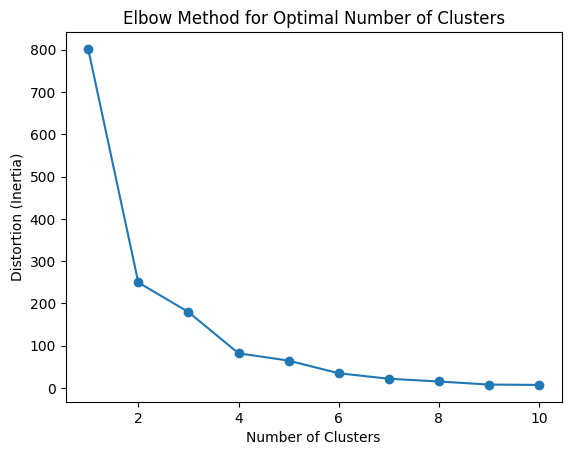

In [8]:
features_for_clustering = processed_user_data[['PCA1', 'PCA2', 'PCA3']]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)
    
# Plotting the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.show()

                         _id      PCA1      PCA2      PCA3  cluster
0   65a713cc1dfebcf6ca173f0d -2.270148  0.374166 -0.640058        9
1   65a714291dfebcf6ca173f0e -2.197261  0.106193  1.400659        8
2   65a714641dfebcf6ca173f0f -1.917151 -1.027056 -0.492096        0
3   65a71f2e1dfebcf6ca173f12 -0.147049 -0.988294  2.452966        3
4   65a723fd1dfebcf6ca173f15 -1.649280  0.237549  0.520251        4
..                       ...       ...       ...       ...      ...
82  65aadc741d099129aa714f80  2.606265 -1.065385 -0.787077        5
83  65aadc851d099129aa714f81  2.749053 -1.170769 -0.760565        5
84  65aadc911d099129aa714f82  2.789987 -1.197952 -0.798633        5
85  65aadca61d099129aa714f83  3.095547 -1.432555 -0.604892        5
86  65aadcbb1d099129aa714f84  3.523911 -1.748708 -0.525356        5

[87 rows x 5 columns]


['/Users/aya/Desktop/ML/insurance-recommender/src/ml/models/kmeans_model.joblib']

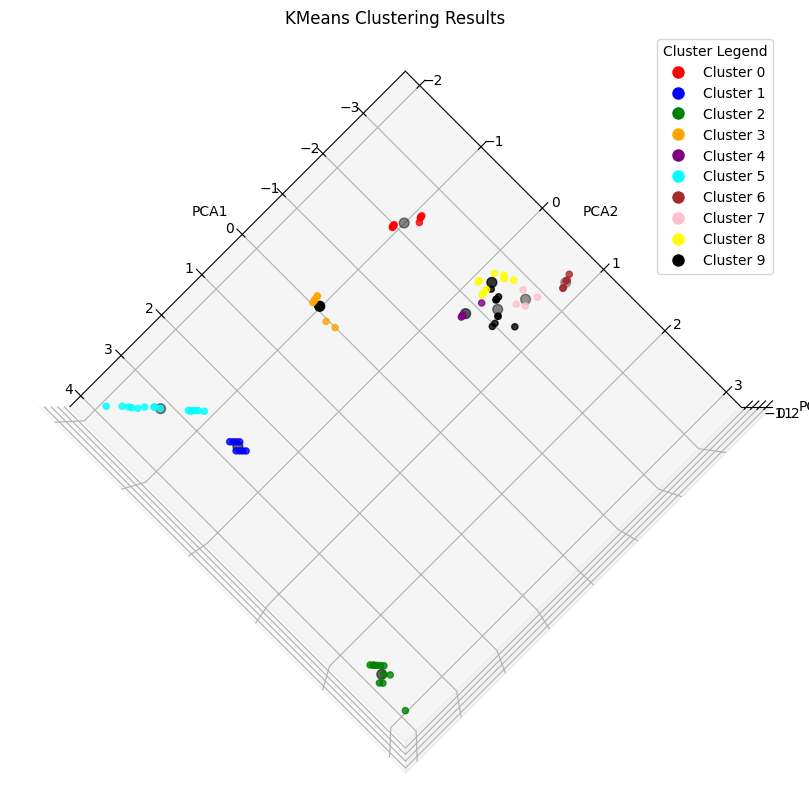

In [10]:
import joblib
import pandas as pd
# Based on the Elbow Method, choose the optimal number of clusters
optimal_clusters = 10  # Choose the point where the distortion starts to decrease more slowly (the "elbow")

# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters)
processed_user_data['cluster'] = kmeans.fit_predict(features_for_clustering)
processed_user_data.to_csv('/Users/aya/Desktop/ML/insurance-recommender/data/processed/users_clusters.csv', index=False)

centroids = kmeans.cluster_centers_
print(processed_user_data)

# Visualize the clustering results with a 3D scatter plot
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink','yellow','black']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='.', s=200, c='black', label='Centroids')

scatter = ax.scatter(processed_user_data['PCA1'], processed_user_data['PCA2'], processed_user_data['PCA3'], c=[cluster_colors[i] for i in processed_user_data['cluster']], alpha=0.8)
ax.set_title('KMeans Clustering Results')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# ADD legend
legend_labels = [f'Cluster {i}' for i in range(optimal_clusters)]
legend2 = ax.legend(
    [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in cluster_colors],
    legend_labels,
    loc='upper right',
    title='Cluster Legend'
)

ax.view_init(elev=90, azim=45) 

model_save_path = '/Users/aya/Desktop/ML/insurance-recommender/src/ml/models/kmeans_model.joblib'
# Save the model using joblib
joblib.dump(kmeans, model_save_path)

In [15]:
#  dictionary used to map each user to its corresponding cluster, allowing you to easily check the cluster assignment of a user given their ID.
user_cluster_mapping = dict(zip(processed_user_data['_id'], processed_user_data['cluster']))

# the cluster of the new data point to predict
target_cluster = 6

# filtering only the similar users of the new data point
target_cluster_users = processed_user_data[processed_user_data['cluster'] == target_cluster]['_id'].tolist()
target_cluster_users

['65a724811dfebcf6ca173f16',
 '65a9c1bd02478feb98fc38fa',
 '65a9c1c902478feb98fc38fb',
 '65a9c1d202478feb98fc38fc',
 '65a9c1e202478feb98fc38fd']

In [142]:
import pandas as pd

contract_record =load_raw_data("/Users/aya/Desktop/ML/insurance-recommender/data/raw/contract_record.csv")

# pick only the records of similar users
filtered_contract_record = contract_record[contract_record['user_id'].isin(target_cluster_users)]

# construct the matrix
user_item_matrix = pd.pivot_table(filtered_contract_record, values='rating', index='user_id', columns='insurance_policy_id', fill_value=0)
print(user_item_matrix)

insurance_policy_id       65a725a01dfebcf6ca173f18  65a7d76ac6eac4ba334646b7
user_id                                                                     
65a724811dfebcf6ca173f16                       4.0                       5.0


In [143]:
import numpy as np

average_ratings = np.mean(user_item_matrix, axis=0)
average_ratings

insurance_policy_id
65a725a01dfebcf6ca173f18    4.0
65a7d76ac6eac4ba334646b7    5.0
dtype: float64

In [144]:
top3_recommendations = average_ratings.sort_values(ascending=False).head(3).index
top3_recommendations.tolist()

['65a7d76ac6eac4ba334646b7', '65a725a01dfebcf6ca173f18']

In [145]:
# here im just saving the model
import joblib

processed_data_path = '/Users/aya/Desktop/ML/insurance-recommender/data/processed/processed_user_data.csv'
processed_user_data = load_raw_data(processed_data_path)
features_for_clustering = processed_user_data[['PCA1', 'PCA2', 'PCA3']]
kmeans = KMeans(n_clusters=9)
processed_user_data['cluster'] = kmeans.fit_predict(features_for_clustering)



/Users/aya/.local/share/virtualenvs/insurance-recommender-AUj_LIzY/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
